In [98]:
# Built-in
from pathlib import Path

# Third-party
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy.signal import find_peaks_cwt
from matplotlib import pyplot as plt
from matplotlib import cm
import seaborn as sns
import pandas as pd
import numpy as np

# Local imports
from polya.utils import smooth

styles = ['../polya.mplstyle']


In [117]:
experiment = 'rip-bpa'

datadir = Path("/casa/joha/zenodo/bpa/")/experiment

fnames = sorted(list(datadir.glob("*.txt")))
fnames

[PosixPath('/casa/joha/zenodo/bpa/rip-bpa/Exp1_T11_RIP_cyto_BPA.txt'),
 PosixPath('/casa/joha/zenodo/bpa/rip-bpa/Exp2_HeLaT_RIP_cyto_BPA.txt'),
 PosixPath('/casa/joha/zenodo/bpa/rip-bpa/Exp3_HeLaT_RIP_cyto_BPA.txt')]

In [118]:
smpidx = 0
inpfpath = fnames[smpidx]
work = inpfpath.name
print(work)

samples = {
    "rip-bpa": ["Input", "LARP1", "LARP4"],
    "kd-bpa": ["siNC", "siLARP1", "siLARP4_4B"],
}[experiment]

# Read the data
df = pd.read_csv(inpfpath, sep='\t', header=5, index_col=0).dropna()
print(list(df.columns))
df = df[['Decade1'] + samples + ['Decade2']]
df.head(3)

Exp1_T11_RIP_cyto_BPA.txt
['Decade1', 'Input', 'LARP1', 'LARP4', 'LARP4B', 'Decade2']


,Decade1,Input,LARP1,LARP4,Decade2
(pixel),,,,,
0,145362.0735,146368.8661,165762.8858,154543.2293,150408.9270
1,148393.7948,148800.2324,162522.7034,161981.6148,149454.8735
2,141866.4092,146807.8849,160101.7130,163956.0270,152658.9649


### Find the marker peaks

[  18  301  754 1101 1363 1564 1725 1851 1958 2047 2381 2783]


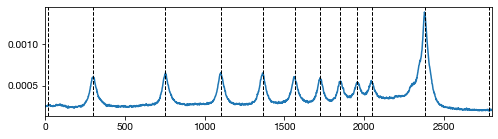

In [119]:
marker_colidx = 0

# Normalize signal intensities by lane and reverse it
df = df.div(df.sum(), axis="columns")[::-1].reset_index(drop=True)

marker_density = df.iloc[:,marker_colidx]
peaks_found = find_peaks_cwt(marker_density.dropna(), np.arange(17, 100), min_snr=1, noise_perc=10) # peak calling
print(peaks_found)

# Visualization of the peak for manual curation
fig = plt.figure(figsize=(8,2))
ax = fig.add_subplot(111)
marker_density.plot(ax=ax)
for x in peaks_found: ax.axvline(x, color='black', linestyle='dashed', linewidth=1)
# ax.set_xticks(peaks_found)
# ax.set_xticklabels(np.arange(0,len(peaks_found)))

plt.show()

### Manually add or remove the marker peaks

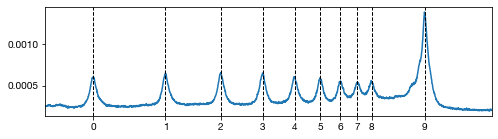

In [120]:
to_add = {
    'Exp2_HeLa_KD_cyto_BPA.txt':[1690],
    'Exp3_A549_KD_cyto_BPA.txt':[1690],
}.get(work, [])
to_remove ={
    'Exp1_T11_RIP_cyto_BPA.txt':[18, 2783],
    'Exp2_HeLaT_RIP_cyto_BPA.txt': [16, 2542],
    'Exp3_HeLaT_RIP_cyto_BPA.txt': [17, 455, 2287],
    
    'Exp1_T11_KD_cyto_BPA.txt':[17, 2456],
    'Exp2_HeLa_KD_cyto_BPA.txt':[15, 2099, 2252, 2384, 2484, 2611],
    'Exp3_A549_KD_cyto_BPA.txt':[15, 2099, 2252, 2384, 2484, 2611],
}[work]

marker_peaks = list(peaks_found) + to_add
marker_peaks = sorted(list(set(peaks_found) - set(to_remove)))

# Visualization of the peak for manual curation
fig = plt.figure(figsize=(8,2))
ax = fig.add_subplot(111)
marker_density.plot(ax=ax)
for x in marker_peaks: ax.axvline(x, color='black', linestyle='dashed', linewidth=1)
for x in to_add: ax.axvline(x, color="orange", ls="--", lw=1)
ax.set_xticks(marker_peaks)
ax.set_xticklabels(np.arange(0,len(marker_peaks)))

plt.show()

In [121]:
marker_labels = [20,30,40,50,60,70,80,90,100,150]

assert len(marker_labels) == len(marker_peaks)

### Draw plots

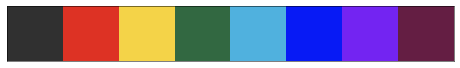

{'Input': '#303030', 'LARP1': '#DD3224', 'LARP4': '#F4D348'}


In [122]:
with plt.style.context(styles):
    palette = plt.rcParams['axes.prop_cycle'].by_key()['color']
    sns.palplot(palette)
    plt.show()
    
    colors = dict(zip(samples, palette))
    print( colors )

Plot separately

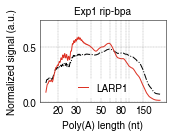

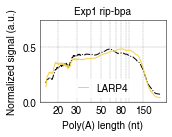

In [124]:
# Draw a figure

savefig = False
minifig = True


# samples for embedding in every figure
embedsmp = ["Input"] 
# embedsmp = ["siNC"]
subsamples = samples

figsize = [4.5, 3]

if minifig is True: 
    styles.append("../mini.mplstyle")
    figsize = list(np.array(figsize) / 2)
with plt.style.context(styles):
    for si, smp in enumerate(subsamples[1:]):
        fig, ax = plt.subplots(figsize=figsize)

        for esmp in embedsmp:
            density = smooth(np.array(df.loc[:,esmp]), 50) * 1000
            ax.plot(density, ls="-.", color="black", label="")
                
        density = smooth(np.array(df.loc[:,smp]), 50) * 1000
        ax.plot(density, color=colors[smp], label=smp)
        
        ax.grid(True)
        ax.set_ylim([0,0.75])
        ax.set_yticks([0,0.5])
        ax.legend(loc="lower center", ncol=2, columnspacing=0.5, handlelength=1.0)
          
        ax.set_xticks(marker_peaks)
        marker_sizes = [20,30,50,80,150]
        ax.set_xticklabels([m if m in marker_sizes else "" for m in marker_labels])

        ## Shared labels
        ax = fig.add_subplot(111, frameon=False)
        ax.set_xticks([]); ax.set_yticks([])
        ax.set_xlabel("Poly(A) length (nt)", labelpad=18)
        ax.set_ylabel("Normalized signal (a.u.)", labelpad=23)
        ax.set_title(f"{work.split('_')[0]} {experiment}", fontsize="medium")


        fname_adduct = ""
        if minifig: fname_adduct += "_mini"
        if savefig is True:
            outfigdir = Path("../plots")
            outfigname = f"{experiment}_{work.split('_')[0]}_{smp}" + fname_adduct + ".pdf"
            outfigpath = outfigdir/outfigname
            print( outfigpath )

            fig.savefig(outfigpath, dpi=300, bbox_inches="tight")

        plt.show()


log2fc 1d heatmap

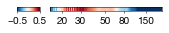

In [126]:
savefig = False
ctrl, tret = "Input", "LARP1"
# ctrl, tret = "siNC", "siLARP1"
vmin, vmax = -0.5, 0.5
markers_to_include = [20, 30, 50, 80, 150]

ctrl_intensity = smooth(np.array(df.loc[:,ctrl]), 50) * 1000
tret_intensity = smooth(np.array(df.loc[:,tret]), 50) * 1000
log2fc = np.log2(tret_intensity / ctrl_intensity)
# log2fc = df[tret].div(df[ctrl]).map(np.log2)
figsize = 2.6, 0.08

with plt.style.context(['../polya.mplstyle', '../mini.mplstyle', '../tick.mplstyle']): 
    fig, ax = plt.subplots(figsize=figsize)
    im = ax.pcolormesh(np.asarray(log2fc).reshape(-1,1).T, cmap=cm.RdBu_r, vmin=vmin, vmax=vmax)

    marker_dict = dict(zip(marker_labels, marker_peaks))
    xticks = [marker_dict[m] for m in markers_to_include]
    ax.set_xticks(xticks)
    ax.set_xticklabels(markers_to_include)
    ax.set_yticks([])

    divider = make_axes_locatable(ax)
    cax = divider.append_axes("left", size="20%", pad=0.15)
    cbar = plt.colorbar(im, cax=cax, orientation="horizontal")
    cbar.set_ticks([vmin, vmax])
    cbar.solids.set_rasterized(True)

    fname_adduct = ""
    if minifig: fname_adduct += "_mini"
    if savefig is True:
        outfigdir = Path("../plots")
        outfigname = f"{experiment}_{work.split()[0]}_{tret}_log2fc" + fname_adduct + ".pdf"
        outfigpath = outfigdir/outfigname
        print( outfigpath, 'saved' )

        fig.savefig(outfigpath, dpi=300, bbox_inches="tight")

plt.show()

x-linearized log2fc 1d heatmap

In [127]:
# Add the size column to linearize the range within marker limits

sizes = list()
for pi, size in enumerate(marker_labels):
    if pi + 1 == len(marker_peaks): break
    pos = marker_peaks[pi]
    nextpos = marker_peaks[pi+1]
    nextsize = marker_labels[pi+1]
    nsigs = nextpos - pos
    sizes += list(np.linspace(size, nextsize, nsigs+1)[:-1])
sizes += [marker_labels[-1]]
df["size"] = None
df.iloc[marker_peaks[0]:marker_peaks[-1]+1, -1] = sizes

In [128]:
# Draw a x-linearised log2 foldchange of the signals
nbins = 1000
binsize = (marker_peaks[-1] - marker_peaks[0]) / nbins
df_temp = df.copy()
df_temp.loc[:, "binid"] = df_temp.loc[:,"size"] // binsize
df_binned = df_temp.groupby("binid").agg(np.sum)

def get_size_from_binid(bid):
    return bid * binsize + (binsize / 2)

df_binned.head(3)

,Decade1,Input,LARP1,LARP4,Decade2
binid,,,,,
9.0,0.017801,0.012013,0.013324,0.012942,0.015613
10.0,0.026510,0.031259,0.037443,0.032935,0.024354
11.0,0.023509,0.032062,0.039541,0.031606,0.022528


../plots/rip-bpa_Exp1_LARP1_linearized_log2fc_mini.pdf saved


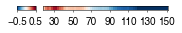

0.4285612528941957 32.24
0.4142700743309381 30.16
0.351720742892344 34.32
0.34806267132398605 28.08
0.30247330915345244 23.92
0.28959863355638155 36.4
0.266695087002962 26.0
0.260397941051736 21.84
0.2540792913013438 38.48
0.2009484485898803 40.56
0.15436879374397466 57.2
0.15222228934993343 55.12
0.14948265236388233 19.759999999999998
0.14833543074581498 50.96
0.14785678226285498 59.28
0.1477526300185538 42.64
0.14082265168737423 48.88
0.13402641507489046 53.04
0.13154692973266463 46.800000000000004
0.1295104157903408 61.36
0.11401560373448291 44.72
0.0859849840799619 63.440000000000005
0.040621723408672046 65.52000000000001
-0.027388911139436808 67.60000000000001
-0.08948866026110354 69.68
-0.12539809934193472 71.76
-0.1428144562310492 73.84
-0.15552306278785138 75.92
-0.16708515294479093 82.16000000000001
-0.16739361877340755 78.00000000000001
-0.17656267329964181 84.24000000000001
-0.1774894985460243 86.32000000000001
-0.177900622855827 80.08000000000001
-0.19716303612042074 88.4
-

In [129]:
savefig = True
minifig = True

figsize = 5.4, 2.4

if minifig is True: 
    styles.append("../mini.mplstyle")
    figsize = list(np.array(figsize) / 2)
    
# ctrl, tret = "siNC", "siLARP1"
# vmin, vmax = -0.4, 0.4
ctrl, tret = "Input", "LARP1"
vmin, vmax = -0.5, 0.5

with plt.style.context(styles + ["../tick.mplstyle"]):
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(111)

    log2fc = np.log2(df_binned.loc[:, tret] / df_binned.loc[:, ctrl])

    d = np.vstack((log2fc, log2fc))

    im = ax.imshow(d, cmap=cm.RdBu_r, vmin=vmin, vmax=vmax)

    xticklabels = list(range(30, 151, 20))
    xticks = (xticklabels // binsize) - (marker_labels[0] // binsize)
    ax.set_xticks(xticks)
    ax.set_xticklabels(xticklabels)
    ax.set_yticks([])

    divider = make_axes_locatable(ax)
    cax = divider.append_axes("left", size="15%", pad=0.1)
    cbar = plt.colorbar(im, cax=cax, orientation="horizontal")
    cbar.set_ticks([vmin, vmax])
    cbar.solids.set_rasterized(True)

    fname_adduct = ""
    if minifig: fname_adduct += "_mini"
    if savefig is True:
        outfigdir = Path("../plots")
        outfigname = f"{experiment}_{work.split('_')[0]}_{tret}_linearized_log2fc" + fname_adduct + ".pdf"
        outfigpath = outfigdir/outfigname
        print( outfigpath, 'saved' )

        fig.savefig(outfigpath, dpi=300, bbox_inches="tight")

    plt.show()

for i in log2fc.sort_values(ascending=False).head(50).index:
    print( log2fc.loc[i], get_size_from_binid(i) )

Plot combined

KeyError: 'Input'

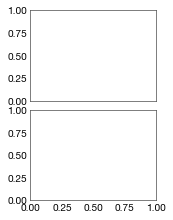

In [115]:
# Draw a figure

savefig = False
minifig = True


# samples for embedding in every figure
embedsmp = ["Input"] 
# embedsmp = ["siNC"]
subsamples = samples
nrows = 2

figsize = [4.5, 3 + 2 * nrows]

styles = ["barricade"]
if minifig is True: 
    styles.append("mini")
    figsize = list(np.array(figsize) / 2)
with plt.style.context(styles):

    fig, axes = plt.subplots(nrows, 1, figsize=figsize, sharex=True, sharey=True)
    plt.subplots_adjust(hspace=0.1)

    axi = 0
    for si, smp in enumerate(subsamples[1:]):
        ax = axes.ravel()[axi]

        for esmp in embedsmp:
            density = smooth(np.array(df.loc[:,esmp]), 50) * 1000
            ax.plot(density, ls="-.", color="black", label="")
                
        density = smooth(np.array(df.loc[:,smp]), 50) * 1000
        ax.plot(density, color=colors[smp], label=smp)
        
        ax.grid(True)
        ax.set_ylim([0,0.65])
        ax.set_yticks([0,0.5])
        ax.legend(loc="lower center", ncol=2, columnspacing=0.5, handlelength=1.0)
        
        if smp != 'LARP4': axi += 1
          
    ax.set_xticks(marker_peaks)
    marker_sizes = [20,30,50,80,150]
    ax.set_xticklabels([m if m in marker_sizes else "" for m in marker_labels])
    
    ## Shared labels
    ax = fig.add_subplot(111, frameon=False)
    ax.set_xticks([]); ax.set_yticks([])
    ax.set_xlabel("Poly(A) length (nt)", labelpad=18)
    ax.set_ylabel("Normalized signal intensity (a.u.)", labelpad=23)
    ax.set_title(work, fontsize="medium")

    
    fname_adduct = ""
    if minifig: fname_adduct += "_mini"
    if savefig is True:
        outfigdir = Path("../plots")
        outfigname = f"bpa_densitogram_{work}_{''.join(subsamples[1:])}" + fname_adduct + ".pdf"
        outfigpath = outfigdir/outfigname
        print( outfigpath )
        
        fig.savefig(outfigpath, dpi=300, bbox_inches="tight")
    
    plt.show()
    